In [1]:
import pandas as pd
%pylab inline
import numpy as np
import matplotlib
import music21 as mu
import pymongo
from pymongo import MongoClient
from bs4 import BeautifulSoup
import re

Populating the interactive namespace from numpy and matplotlib


In [2]:
xmlData = BeautifulSoup(open('FinalDataSet/XMLFiles/JazzSolos/KJAllTheThingsYouAre1983_2143_290.xml'))

In [3]:
#notesDataFrame = pd.DataFrame
#notes = xmlData.find_all('note')
#print xmlData

In [4]:
allNotes = xmlData.findAll('note')

In [5]:
#allNotes

In [6]:
listOfNoteEvents = []
for note in allNotes:
    #print note.pitch
    #print note.instrument.attrs.values()
    #print 'end'
    dictForNoteEvent = {}
    dictForNoteEvent['restFlag'] = note.rest
    dictForNoteEvent['noteName'] = note.step
    dictForNoteEvent['octave'] = note.octave
    dictForNoteEvent['duration'] = note.duration.text
    dictForNoteEvent['instrument'] = note.instrument.attrs.values()
    dictForNoteEvent['accidental'] = note.alter
    
    listOfNoteEvents.append(dictForNoteEvent)



In [7]:
df = pd.DataFrame(listOfNoteEvents)

In [8]:
df.head()

,accidental,duration,instrument,noteName,octave,restFlag
0,None,256,[P1-I1],None,None,<rest></rest>
1,<alter>-1</alter>,256,[P1-I1],<step>B</step>,<octave>4</octave>,None
2,<alter>-1</alter>,512,[P1-I1],<step>A</step>,<octave>4</octave>,None
3,None,384,[P1-I1],<step>C</step>,<octave>5</octave>,None
4,None,128,[P1-I1],<step>G</step>,<octave>4</octave>,None


In [9]:
# first clean of data
def cleanAccidental(data_row):
    accidentalString = str(data_row['accidental'])
    test = re.sub('<[^>]*>', '', accidentalString)
    return str(test) 
    
df['accidental'] = df.apply(cleanAccidental, axis=1) 

def cleanNoteName(data_row):
    accidentalString = str(data_row['noteName'])
    test = re.sub('<[^>]*>', '', accidentalString)
    return str(test) 
    
df['noteName'] = df.apply(cleanNoteName, axis=1) 

def cleanOctave(data_row):
    accidentalString = str(data_row['octave'])
    test = re.sub('<[^>]*>', '', accidentalString)
    return str(test) 
    
df['octave'] = df.apply(cleanOctave, axis=1) 


        
def cleanRest(data_row):
    restVal = -1
    restAsString = str(data_row['restFlag'])
    if restAsString != 'None':
        restVal ='rest'
    else:
        restVal = 'note'

    return str(restVal)
    
df['restFlag'] = df.apply(cleanRest, axis=1)



In [10]:
df['restFlag'].value_counts()

note    2143
rest     260
dtype: int64

In [11]:
#second clean for parts and duration
def cleanPart(data_row):
    accidentalString = str(data_row['instrument'])
    test = accidentalString[3:5]
    return str(test) 

df['part'] = df.apply(cleanPart, axis=1)

def convertDurationAsPerQuarterNoteIsOneBeat(data_row):
    asFloat = float(data_row['duration'])
    return asFloat / 256

df['quarterNoteDuration'] = df.apply(convertDurationAsPerQuarterNoteIsOneBeat, axis=1)

In [12]:
df.head()

,accidental,duration,instrument,noteName,octave,restFlag,part,quarterNoteDuration
0,None,256,[P1-I1],None,None,rest,P1,1.0
1,-1,256,[P1-I1],B,4,note,P1,1.0
2,-1,512,[P1-I1],A,4,note,P1,2.0
3,None,384,[P1-I1],C,5,note,P1,1.5
4,None,128,[P1-I1],G,4,note,P1,0.5


In [13]:
# divide parts to ascertain location
partOne = df[df['part'] == 'P1']
partTwo = df[df['part'] == 'P2']

In [14]:
partOne['noteEventLocation'] = partOne['quarterNoteDuration'].cumsum()
partTwo['noteEventLocation'] = partTwo['quarterNoteDuration'].cumsum()

partOne['noteEventStartingLocation'] = partOne['noteEventLocation'].shift()
partTwo['noteEventStartingLocation'] = partTwo['noteEventLocation'].shift()


In [15]:
df = pd.concat([partOne, partTwo], axis=0)

In [16]:
df.head(3)

,accidental,duration,instrument,noteName,octave,restFlag,part,quarterNoteDuration,noteEventLocation,noteEventStartingLocation
0,None,256,[P1-I1],None,None,rest,P1,1,1,NaN
1,-1,256,[P1-I1],B,4,note,P1,1,2,1
2,-1,512,[P1-I1],A,4,note,P1,2,4,2


In [17]:
#df = df.sort('noteEventLocation')
#df = df.reset_index()

In [18]:
df.head(10)

,accidental,duration,instrument,noteName,octave,restFlag,part,quarterNoteDuration,noteEventLocation,noteEventStartingLocation
0,None,256,[P1-I1],None,None,rest,P1,1.0,1.0,NaN
1,-1,256,[P1-I1],B,4,note,P1,1.0,2.0,1.0
2,-1,512,[P1-I1],A,4,note,P1,2.0,4.0,2.0
3,None,384,[P1-I1],C,5,note,P1,1.5,5.5,4.0
4,None,128,[P1-I1],G,4,note,P1,0.5,6.0,5.5
5,None,256,[P1-I1],F,4,note,P1,1.0,7.0,6.0
6,None,256,[P1-I1],E,4,note,P1,1.0,8.0,7.0
7,None,128,[P1-I1],None,None,rest,P1,0.5,8.5,8.0
8,None,128,[P1-I1],F,4,note,P1,0.5,9.0,8.5
9,None,128,[P1-I1],F,4,note,P1,0.5,9.5,9.0


In [19]:
#del df['index']
del df['duration']
del df['instrument']
del df['noteEventLocation']

In [20]:
df.head()

,accidental,noteName,octave,restFlag,part,quarterNoteDuration,noteEventStartingLocation
0,None,None,None,rest,P1,1.0,NaN
1,-1,B,4,note,P1,1.0,1.0
2,-1,A,4,note,P1,2.0,2.0
3,None,C,5,note,P1,1.5,4.0
4,None,G,4,note,P1,0.5,5.5


In [21]:
#create midi frequency value
offsetForC = 0
offsetForD = 2
offsetForE = 4
offsetForF = 5
offsetForG = 7
offsetForA = 9
offsetForB = 11

def midiNumberAssign(data_row):
    
    def adjustForAccidental(accidentalVal):
        if accidentalVal == 'None':
            return 0
        else:
            return int(accidentalVal)

    if data_row['octave'] != "None":
        baseVal = int(data_row['octave']) * 12
        if data_row['noteName'] == 'C':
            return baseVal + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'D':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'E':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'F':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'G':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'A':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'B':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])



df['midiNumber'] = df.apply(midiNumberAssign, axis=1)

In [22]:
df.dtypes

accidental                    object
noteName                      object
octave                        object
restFlag                      object
part                          object
quarterNoteDuration          float64
noteEventStartingLocation    float64
midiNumber                   float64
dtype: object

In [23]:
df.head(10)

,accidental,noteName,octave,restFlag,part,quarterNoteDuration,noteEventStartingLocation,midiNumber
0,None,None,None,rest,P1,1.0,NaN,NaN
1,-1,B,4,note,P1,1.0,1.0,49
2,-1,A,4,note,P1,2.0,2.0,49
3,None,C,5,note,P1,1.5,4.0,60
4,None,G,4,note,P1,0.5,5.5,50
5,None,F,4,note,P1,1.0,6.0,50
6,None,E,4,note,P1,1.0,7.0,50
7,None,None,None,rest,P1,0.5,8.0,NaN
8,None,F,4,note,P1,0.5,8.5,50
9,None,F,4,note,P1,0.5,9.0,50


In [24]:
#get rid of unused columns

del df['accidental']
del df['noteName']
del df['octave']

In [25]:
df['noteEventStartingLocation'].fillna(0.0, inplace=True)

In [26]:
#df['midiNumber'].fillna(-1, inplace=True)

In [27]:
df.head()

,restFlag,part,quarterNoteDuration,noteEventStartingLocation,midiNumber
0,rest,P1,1.0,0.0,NaN
1,note,P1,1.0,1.0,49
2,note,P1,2.0,2.0,49
3,note,P1,1.5,4.0,60
4,note,P1,0.5,5.5,50


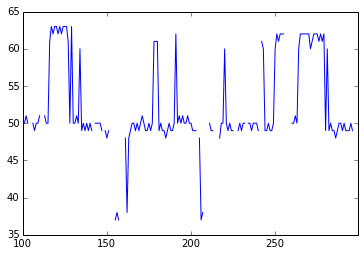

In [28]:
df[df['part'] == 'P1']['midiNumber'][100:300].plot()

In [29]:
#find sequences and ngrams

In [30]:
partOneAsMatrix = df[df['part'] == 'P1']
matrix = partOneAsMatrix[['part','quarterNoteDuration','noteEventStartingLocation', 'midiNumber']].as_matrix()

In [31]:
matrix[0:10]

array([['P1', 1.0, 0.0, nan],
       ['P1', 1.0, 1.0, 49.0],
       ['P1', 2.0, 2.0, 49.0],
       ['P1', 1.5, 4.0, 60.0],
       ['P1', 0.5, 5.5, 50.0],
       ['P1', 1.0, 6.0, 50.0],
       ['P1', 1.0, 7.0, 50.0],
       ['P1', 0.5, 8.0, nan],
       ['P1', 0.5, 8.5, 50.0],
       ['P1', 0.5, 9.0, 50.0]], dtype=object)

In [95]:
#create 
threeNoteSequences = []
phraseLength = 3


for x in range(len(matrix)):
    noteTuple= []
    currentNote = matrix[x][3]
    #print matrix[x]
    noteTuple.append(str(currentNote))
    #secondNote = None
    #thirdNote = None
    
    try:
        secondNote = matrix[x+1][3]
        noteTuple.append(str(secondNote))
        
    except: 
        pass
    
    try:
        thirdNote = matrix[x+2][3]
        noteTuple.append(str(thirdNote))
    except: 
        pass
    
    threeNoteSequences.append(noteTuple)
    
    


#print threeNoteSequences

In [100]:
df2 = pd.DataFrame(threeNoteSequences, columns=['one', 'two', 'three'])

In [103]:
df2['next'] = (df2['one'] +  df2['two'] +  df2['three'])

In [106]:
len(df2['next'].value_counts())

421

In [84]:
df2['merged'] = str(df2[1]) + ',' + str(df2[2])

In [91]:
df2['merged'].value_counts()

0       49\n1       49\n2       60\n3       50\n4       50\n5       50\n6      NaN\n7       50\n8       50\n9       50\n10      50\n11      49\n12      49\n13     NaN\n14     NaN\n15      49\n16      60\n17      61\n18      61\n19      50\n20      50\n21      49\n22      60\n23      60\n24      50\n25      50\n26     NaN\n27      50\n28      50\n29      50\n        ..\n2028   NaN\n2029   NaN\n2030   NaN\n2031   NaN\n2032   NaN\n2033   NaN\n2034   NaN\n2035   NaN\n2036   NaN\n2037   NaN\n2038   NaN\n2039   NaN\n2040   NaN\n2041   NaN\n2042   NaN\n2043   NaN\n2044   NaN\n2045   NaN\n2046   NaN\n2047   NaN\n2048   NaN\n2049   NaN\n2050   NaN\n2051   NaN\n2052   NaN\n2053   NaN\n2054   NaN\n2055   NaN\n2056   NaN\n2057   NaN\nName: 1, dtype: float64,0       49\n1       60\n2       50\n3       50\n4       50\n5      NaN\n6       50\n7       50\n8       50\n9       50\n10      49\n11      49\n12     NaN\n13     NaN\n14      49\n15      60\n16      61\n17      61\n18      50\n19      50\n20  

In [74]:
df2 = df.groupby(['noteEventStartingLocation'])